In [5]:
pip install --upgrade GPy
pip install --upgrade numpy
#pip install -U numpy
pip install --upgrade GPyOpt


SyntaxError: invalid syntax (<ipython-input-5-0087a2756cc3>, line 1)

In [6]:
# %load main.py
"""
Created on Sat Jul 10 21:27:20 2021

@author: user
"""

#%%
import os
import pandas as pd
import math
import glob
import numpy as np
import matplotlib.pyplot as plt
import copy
from sklearn.model_selection import train_test_split
import random
import time
from sklearn.metrics import f1_score, make_scorer
import statistics

import Helper.File.FileHelper as FileHelper
import Property
import Plot
import Preprocess.StatisticValue as PreStatVal
#import FeatureSelection.FeatureSelection as FeatureSelection
import dataToC.dataToC as dataToC
import dataFromC.dataFromC as dataFromC
import IsolationForest.IsolationForest as myIsolationForest

#%%
def MergeCsv():  
    #merge csv file (Span 1 ~ 6)
    for idx in range(0, len(Property.Experiment().MERGED_FILE_NAME)):
        FileHelper.MergeAllFile(Property.Experiment().PATH_RELATIVE[idx], '.csv', 
                                Property.Experiment().MERGED_FILE_NAME[idx], None, 
                                [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 
                                Property.Experiment().FIRST_FILE, 
                                Property.Experiment().LAST_FILE)

def GetRawDataFromCsv():     
    # [0~5] for Each Span 1 ~ 6
    raw_data = []
    # Read CSV File
    for i in range(len(Property.Experiment().MERGED_FILE_NAME)):
        path = os.path.abspath(os.getcwd()) + Property.Experiment().PATH_RELATIVE[i] + '\\' + Property.Experiment().MERGED_FILE_NAME[i]
        merged_data = pd.read_csv(path, names=Property.Experiment().COL_NAME, index_col=False)
        raw_data.append(merged_data)
    return raw_data

def AddSpanLabel(X_processed):
    X_processed = copy.deepcopy(X_processed)
    span_processed_X = [] 
    
    # add label: span
    for i in range(len(X_processed)):
        span_processed_X.append(X_processed[i])
        span_processed_X[i]['Span'] = i+1
    return span_processed_X

def GetDataForFeatureSelection(X_processed):
    span_processed_X = AddSpanLabel(X_processed)   
    # list to df
    span_train_data = pd.DataFrame()
    for i in range(len(span_processed_X)):
        span_train_data = span_train_data.append(span_processed_X[i], ignore_index=True)
    return span_train_data

def ProduceFakeAbnormalData(abnormal_count, Xy_train):   
    # TODO
    fake_degree = 4
    fake_range = 1
    
    cols = Xy_train.columns.tolist()
    cols.remove('Span')
    fake_abnormal_data = pd.DataFrame(columns = cols)
    for col in cols:
        start = Xy_train[Xy_train.Span == 1].loc[:, col].mean()
        end = Xy_train[Xy_train.Span == 2].loc[:, col].mean()
        diff = end - start
        
        extremly_value = 0
        if diff > 0:
            extremly_value = start * fake_degree
            fake_abnormal_data.loc[0, col] = extremly_value
        else:
            extremly_value = 0
            fake_abnormal_data.loc[0, col] = 0
            
        for i in range(1, abnormal_count):
            if extremly_value == 0:
                fake_abnormal_data.loc[i, col] = random.uniform(extremly_value, extremly_value + fake_range)
            else:
                fake_abnormal_data.loc[i, col] = random.uniform(extremly_value, extremly_value - fake_range)
    return fake_abnormal_data
    
def my_custom_loss_func(y_true, anomaly_score, labels):   
    df = pd.concat([y_true, anomaly_score], axis=1, ignore_index=True)
    df.columns = ['Span', "Anomaly_score"]
    
    # 計算每種span的異常分數的平均
    mean = []
    for i in labels:
        mean.append(df[df.Span == i].Anomaly_score.mean())
    
    # 計算平均之間的中點，當作multi-classify的threshold   
    mean_middle = []
    for i in range(len(labels)):
        # 避免超出idx範圍
        if i == len(labels)-1:
            break
        current = mean[i]
        next = mean[i+1]
        mean_middle.append((current + next) / 2)
    

    score = pd.Series.to_list(anomaly_score)
    y_pred = []
    # 多元分類
    # 將每個異常分數與threshold合併並排序，異常分數的idx+1即為prediction
    for i in range(len(score)):
        temp = [score[i]]
        temp.extend(mean_middle)
        temp.sort()
        y_pred.append(temp.index(score[i]) + 1)
    y_pred = pd.Series(y_pred, index=y_true.index)
    
    f1score = f1_score(y_true, y_pred, average='weighted')

    return f1score

# preprocessing

Expriment begin...
Raw data...
Plot PLC cycle
Preprocessing...
Plot preprocess data


<Figure size 504x360 with 0 Axes>

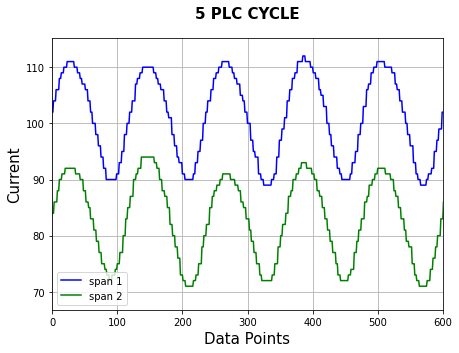

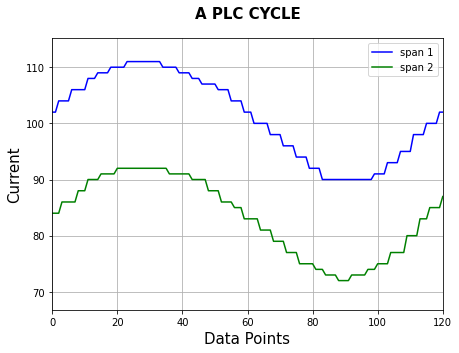

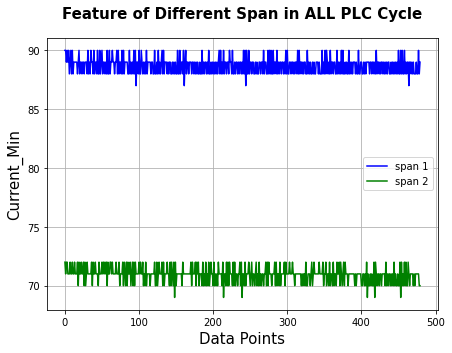

<Figure size 504x360 with 0 Axes>

In [7]:
print('Expriment begin...')

'''
Raw data
'''
print('Raw data...')
# 如果有新的實驗檔案，要重新合併csv檔，把merge的註釋消掉
# MergeCsv()
raw_data = GetRawDataFromCsv()

print('Plot PLC cycle')
spans = ['span 1', 'span 2']
Plot.PlotMultiFeature(list_data = raw_data, feature = 'Current', 
                      xlim = Property.Experiment().PLC_CYCLE * 5, x_axis_label = 'Data Points', 
                      list_labels = spans, 
                      title = '5 PLC CYCLE')
Plot.PlotMultiFeature(list_data = raw_data, feature = 'Current', 
                      xlim = Property.Experiment().PLC_CYCLE, x_axis_label = 'Data Points', 
                      list_labels = spans, 
                      title = 'A PLC CYCLE')



'''
Preprocessing
'''
print('Preprocessing...')

X_processed = []

# 有新資料時，改成True
first_calculated = False
if first_calculated:
    # 把用不到的column拿掉，ex: 時間
    selected_col = ['Output_DC_Bus', 'Torque', 'Voltage',
                          'Power_Factor_Angle', 'RPM', 'Current']
    # 計算統計特徵值
    for i in range(0, len(raw_data)):
        df = pd.DataFrame()
        for j in range(0, len(selected_col)):
            df = pd.concat([df, PreStatVal.CalculateSixFeatureValue(raw_data[i], selected_col[j], Property.Experiment().FIRST_FILE, Property.Experiment().LAST_FILE)], axis=1)
        X_processed.append(df)
    # 刪掉null row    
    for i in range(0, len(X_processed)):
        X_processed[i] = X_processed[i].dropna()
    # save pickle
    for i in range(0, len(X_processed)):
        X_processed[i].to_pickle('pickle/processed_X_' + str(i))    
else:
    # read pickle
    for i in range(0, Property.Experiment().SPAN_COUNT):
        X_processed.append(pd.read_pickle('pickle/processed_X_' + str(i)))  
    
print('Plot preprocess data')
Plot.PlotMultiFeature(list_data = X_processed, feature = 'Current_Min', x_axis_label = 'Data Points', list_labels = spans, title = 'Feature of Different Span in ALL PLC Cycle')
plt.figure(figsize=(7,5))

# Feature selection 

Feature selection...
	 1. extra tree
	 2. random forest
	 3. GBDT
Train & Test data...
	 processing Train data
	 add partial train real abnormal data
data to C++...
Isolation Forest...
	 binary classification
              precision    recall  f1-score   support

          -1       1.00      1.00      1.00       144
           1       1.00      1.00      1.00       144

    accuracy                           1.00       288
   macro avg       1.00      1.00      1.00       288
weighted avg       1.00      1.00      1.00       288

GMM...
span 1
mean = [0.48948766] 	 std = 0.0023923102137489707
span 2
mean = [0.72371123] 	 std = 9.003083077579021e-06


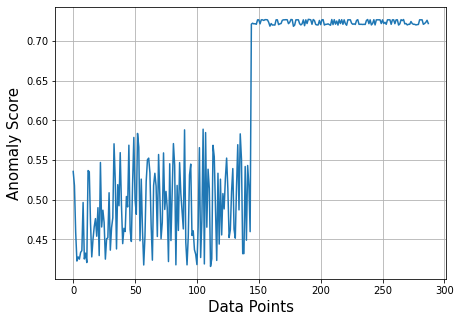

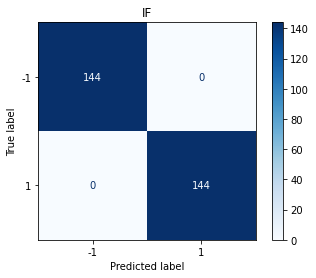

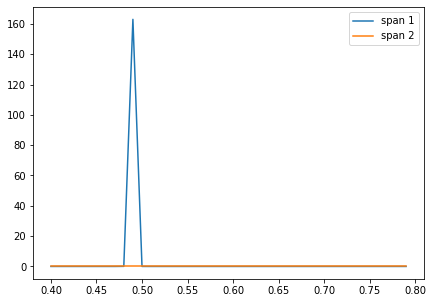

In [8]:
'''
Feature selection
'''
print('Feature selection...')

#
# train & test data for feature selection
#
Xy_all_feat = GetDataForFeatureSelection(X_processed)

all_feat_X = Xy_all_feat.drop('Span', axis=1)
y = Xy_all_feat['Span']

fs_train_X, fs_test_X, fs_train_y, fs_test_y = train_test_split(
    all_feat_X, y, test_size=0.3, random_state=0,stratify=y)

display_multi_labels = ['1', '2']  
labels = [1, 2] 

print('\t 1. extra tree')
# extra_trees = FeatureSelection.ExtraTrees(150, fs_train_X, fs_train_y)
# extra_trees.Predict(fs_test_X)
# extra_trees.ConfusionMatrix(fs_test_y, display_multi_labels)
# extra_trees.PrintImportances()
# extra_trees.PlotImportances()

print('\t 2. random forest')
# random_forest = FeatureSelection.RandomForest( n_estimators = 150, max_features = "sqrt", 
#                                               max_depth = None, min_samples_leaf = 3, 
#                                               X = fs_train_X, y = fs_train_y)
# random_forest.Predict(fs_test_X)
# random_forest.ConfusionMatrix(fs_test_y, display_multi_labels)
# random_forest.PrintImportances()
# random_forest.PlotImportances()

print('\t 3. GBDT')
# gbdt = FeatureSelection.GradientBoostedDecisionTrees(n_estimators = 100, learning_rate = 1, 
#                                                      max_depth = 6, X = fs_train_X, y = fs_train_y)
# gbdt.Predict(fs_test_X)
# gbdt.ConfusionMatrix(fs_test_y, display_multi_labels)
# gbdt.PrintImportances()
# gbdt.PlotImportances()


#seleted_features = ['Span', 'Power_Factor_Angle_Avg', 'Power_Factor_Angle_Max', 'Voltage_Avg', 'Voltage_Max', 'Current_Min']
seleted_features = ['Span', 'Power_Factor_Angle_Avg', 'Power_Factor_Angle_Max', 'Power_Factor_Angle_Min', 'Torque_Min', 'Torque_Avg']
#seleted_features = ['Power_Factor_Angle_Avg','Current_Min',]

# data after feature selection
Xy_selected = Xy_all_feat.loc[:, seleted_features]



'''
Train & Test data 
'''
print('Train & Test data...')
Xy_train, Xy_test, y_train, y_test = train_test_split(Xy_selected, y, test_size=0.3, random_state=0,stratify=y)
# 排序是為了後面的異常分數圖
Xy_test = Xy_test.sort_values(by=['Span'])
X_test = Xy_test.drop(columns = 'Span')
y_test = y_test.sort_values(ascending=True)



normal_span = [1]
abnormal_span = [2]
# = abnormal data 數量 / normal data 數量, range: 0~1
abnormal_ratio = (1.0 / 30.0) / len(abnormal_span)
abnormal_count = 0
for i in abnormal_span:
    abnormal_count += math.floor(abnormal_ratio * Xy_train[Xy_train.Span == i].shape[0])

#
# fake data
#
add_fake_abnormal_X = False
if add_fake_abnormal_X:
    print('\t produce Fake abnormal data')
    fake_abnormal_data = ProduceFakeAbnormalData(abnormal_count, Xy_train)


print('\t processing Train data')
for i in range(1, Property.Experiment().SPAN_COUNT+1) :
    if (i in abnormal_span) and (add_fake_abnormal_X == False):
        print('\t add partial train real abnormal data')
        Xy_temp = Xy_train.loc[Xy_train.Span == i, :]
        # 依異常比例取部分的 train Xy
        Xy_temp = Xy_temp.sample(frac = abnormal_ratio, axis = 0)
        
        # 移除所有的異常資料
        idx = Xy_train.loc[Xy_train.Span == i,:].index
        Xy_train = Xy_train.drop(idx, axis = 0)
        # 加上部分的異常資料
        Xy_train = Xy_train.append(Xy_temp)
    # 正常資料不處理
    elif i in normal_span:
        continue
    # 移除不用的正常資料(不在normal_span的正常資料會被移除)
    else: 
        idx = Xy_train.loc[Xy_train.Span == i,:].index
        Xy_train = Xy_train.drop(idx, axis = 0)
        
if add_fake_abnormal_X == True:
    print('\t add fake abnormal data')
    Xy_train = Xy_train.append(fake_abnormal_data)
    
# shuffle
#Xy_train = Xy_train.sample(frac=1)
X_train = Xy_train.drop(columns='Span')
y_train = Xy_train.Span



'''
C++
'''
print('data to C++...')
dataToC.DataToC(X_train, Xy_test)

# print('data from C++...')
# anomaly_score_from_C = dataFromC.DataFromC()
# for i in range(anomaly_score_from_C.shape[1]):
#     Plot.PlotFeature(anomaly_score_from_C, anomaly_score_from_C.columns[i])



'''
Isolation Forest
'''
print('Isolation Forest...')
IF = myIsolationForest.IF(abnormal_ratio, n_estimators=500, max_samples=20, max_features=5, X_train=X_train)

# label: 正常=1，異常=-1
y_test_bi = y_test.replace(to_replace = y_test[ y_test <= 1 ].tolist(), value=1 )
y_test_bi = y_test_bi.replace(to_replace = y_test[ y_test > 1 ].tolist(), value=-1 )

IF.Predict(X_test, y_test_bi, y_test, labels)
IF.PlotAnomalyScore('')

print('\t binary classification')
IF.ConfusionMatrixBinary([-1, 1], 'IF')
IF.ClassificationReportBinary()

#%%
print('GMM...')

from sklearn.mixture import GaussianMixture
anomaly_score = IF.all_score.values.reshape(-1, 1)
# 非常重要的兩個參數，會直接決定GMM的結果是否成功!
weights_init = [1/len(spans)] * len(spans)
means_init = np.array(IF.means).reshape(-1, 1)
# 因為是1-D的GMM，因此covariance_type='spherical'
gm = GaussianMixture(n_components=len(spans), covariance_type='spherical', 
                     random_state=0, init_params='kmeans', 
                     weights_init=weights_init, means_init=means_init).fit(anomaly_score)

# plot 1-D gaussian distribution
from scipy.stats import norm
plt.figure(figsize=(7, 5))

means = gm.means_
standard_deviations = gm.covariances_

for i in range(0, len(spans)):   
    x = np.arange(0.4, 0.8, 0.01)
    y = norm(means[i], standard_deviations[i])
    
    print('span', i+1)
    print('mean =', means[i], '\t std =', standard_deviations[i])
    
    plt.plot(x, y.pdf(x), label=spans[i])
    plt.legend()

prob = pd.DataFrame(gm.predict_proba(anomaly_score))

# result
true = IF.y_true_mul.reset_index(drop=True)
pred = IF.y_pred_mul.reset_index(drop=True)

true_pred_prob = pd.concat([true, pred], axis=1)
true_pred_prob.columns = ['True', 'Pred']
true_pred_prob = pd.concat([true_pred_prob, prob], axis=1)

true_pred_prob_wrong = true_pred_prob[true_pred_prob['True'] != true_pred_prob['Pred']]

true_pred_prob_wrong.rename(columns={0: 'prob_1', 1: "prob_2", 2: "prob_3", 3: "prob_4", 4: "prob_5", 5: "prob_6",}, inplace = True)

# BO

In [9]:
#%%
print('GPyOpt...')
import GPy
import GPyOpt
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import IsolationForest

def BO_EX(experiment_count, unknown_func, initial_design_numdata, bound): 
    opt_params = pd.DataFrame(columns=['n_estimators', 'max_samples', 'max_features', 'time_cost'])
    max_iter = 30
    max_time = 30
    
    for i in range(experiment_count):
        print('\n\t BO ex', i)
        time_start = time.time() #開始計時
        
        optimizer = GPyOpt.methods.BayesianOptimization(
            f=unknown_func,
            domain=bound,
            acquisition_type ='MPI',
            acquisition_par = 0.1,
            exact_eval=True, 
            initial_design_numdata=initial_design_numdata)
        
        optimizer.run_optimization(max_iter, max_time)
        
        time_end = time.time()    #結束計時
        time_c= time_end - time_start   #執行所花時間
        print('\t', 'time cost', time_c, 's')
        
        # 畫收斂圖
        # optimizer.plot_convergence()
        
        gp_opt = optimizer.X[np.argmin(optimizer.Y)]
        print('\t', gp_opt)
    
        #optimizer.plot_acquisition()    
    
        # 所有實驗的參數結果
        opt_params = opt_params.append({
            'IF_count': gp_opt[0],
            'n_estimators': gp_opt[1], 
            'max_samples': gp_opt[2], 
            'max_features': gp_opt[3],
            'time_cost': time_c}, ignore_index=True)
    print(opt_params.describe())
    return opt_params

GPyOpt...


## unknown func 

In [10]:
#%%
#
# unknown function
#

# Optimizer will try to find minimum, so we will add a "-" sign.
def score_difference_unknown_func(parameters):
    parameters = parameters[0]
    IF_count = int(parameters[0])
    diff_list = []
    for i in range(IF_count):
        clf = IsolationForest(contamination=abnormal_ratio, 
                            random_state=None,
                            n_estimators=int(parameters[1]),
                            max_samples=int(parameters[2]), 
                            max_features=int(parameters[3]))   
        clf.fit(X_train)
        
        # anomaly score
        score = clf.score_samples(X_test)        
        d = {'Anomaly_score' : pd.Series(score * -1, index=X_test.index),
             'y_test' : y_test_bi}
        df = pd.DataFrame(d)
        
        max_normal_score = df[df['y_test']==1].max(axis=0)
        min_anomaly_score = df[df['y_test']==-1].min(axis=0)
        diff_list.append(min_anomaly_score['Anomaly_score'] - max_normal_score['Anomaly_score'])
    diff_min = min(diff_list)
    # diff_max = max(diff_list)
    #print(diff_min)
    
    return -diff_min


def stable_n_estimator_unknown_func(IF_count, n_estimators, max_samples, max_features):
    print('n_estimators = ', n_estimators)
        
    # 建立多個IF，計算多個score difference
    score_diff_list = []
    for i in range(IF_count):
        params = [[1, n_estimators, max_samples, max_features]]
        score_diff_list.append(score_difference_unknown_func(params))

    # 計算最好、最差的score differenc之間的落差
    score_min = -max(score_diff_list)
    score_max = -min(score_diff_list)
    diff_presentage = (score_max - score_min) / score_max
    return score_min, score_max, diff_presentage

## 重複BO，看BO找到的samples分布(BO有效性實驗)

In [11]:
#%% run EX
experiment_count = 2

bound_n_estimators = [1, 200]
# Bounds (NOTE: define continuous variables first, then discrete!)
bound_1 = [   
    {'name': 'IF_count',
      'type': 'discrete',
      'domain': range(1, 2)}, # 設定range(想要的IF_count, IF_count+1)
    
    {'name': 'n_estimators',
      'type': 'discrete',
      'domain': range(bound_n_estimators[1], bound_n_estimators[1]+1)},
    
    {'name': 'max_samples',
     'type': 'discrete',
     'domain': range(2, X_test.shape[0])},

    {'name': 'max_features',
     'type': 'discrete',
     'domain': range(3, 6)}
]

opt_params = pd.DataFrame()

if experiment_count > 0:
    # run EX
    opt_params = BO_EX(experiment_count,  score_difference_unknown_func, 15, bound_1)

    # 存實驗結果
    opt_params.to_pickle('pickle/1000_BO_500TreeCount')


	 BO ex 0
	 time cost 8.951472759246826 s
	 [  1. 200.  76.   3.]

	 BO ex 1
	 time cost 15.271941661834717 s
	 [  1. 200.  56.   3.]
       n_estimators  max_samples  max_features  time_cost  IF_count
count           2.0     2.000000           2.0   2.000000       2.0
mean          200.0    66.000000           3.0  12.111707       1.0
std             0.0    14.142136           0.0   4.469246       0.0
min           200.0    56.000000           3.0   8.951473       1.0
25%           200.0    61.000000           3.0  10.531590       1.0
50%           200.0    66.000000           3.0  12.111707       1.0
75%           200.0    71.000000           3.0  13.691824       1.0
max           200.0    76.000000           3.0  15.271942       1.0


56.0 1
76.0 1


No handles with labels found to put in legend.


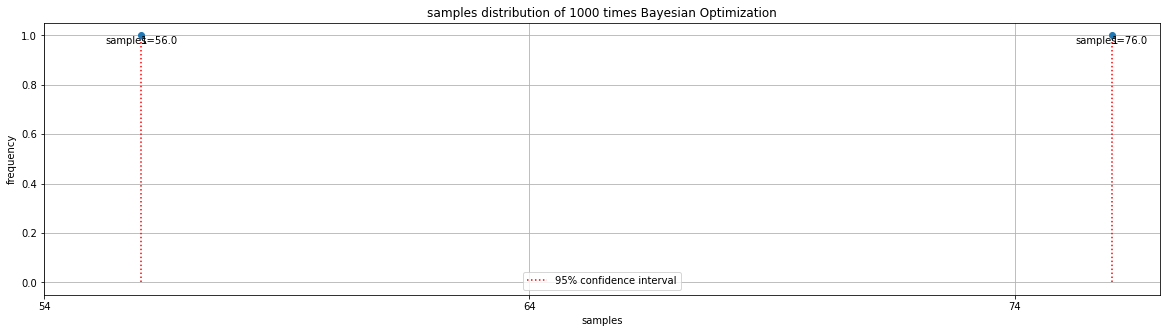

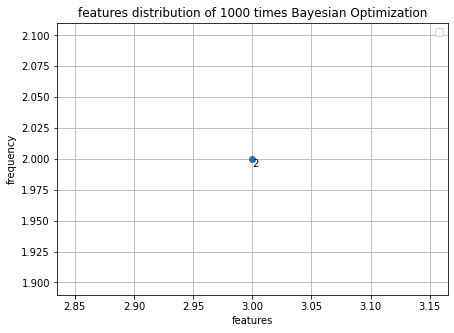

In [12]:
#%% plot result

if experiment_count > 0:    
    #
    # ----- 畫samples分布 ------
    #
    
    # (1)計算每種max_samples出現的頻率
    samples_freq = opt_params.groupby(opt_params['max_samples'].values).size()

    count = 0
    # (2)find 95% confidence interval
    lower_bound = 0
    upper_bound = 0
    find_lower = False
    find_upper = False
    
    for f in samples_freq.index:
        count += samples_freq[f]    
        # 找95%信賴區間的下界
        if count >= (len(opt_params) * 0.025):
            if find_lower == False:
                find_lower = True
                lower_bound = f
                print(f, samples_freq[f])
        # 找95%信賴區間的上界
        if count >= (len(opt_params) * 0.975):
            if find_upper == False:
                find_upper = True
                upper_bound = f
                print(f, samples_freq[f])

    # (3) plot
    plt.figure(figsize=(20,5))
    plt.grid(True)
    
    # plot 95% confidence interval
    plt.plot([lower_bound, lower_bound], [0, samples_freq.max()],  ':', color='r', label='95% confidence interval')
    plt.text(lower_bound, samples_freq.max(), 'samples=' + str(lower_bound), ha='center', va='top')
    plt.plot([upper_bound, upper_bound], [0, samples_freq.max()],  ':', color='r')
    plt.text(upper_bound, samples_freq.max(), 'samples=' + str(upper_bound), ha='center', va='top')
    
    # 畫 samples 分布
    plt.plot(samples_freq, 'o')
    # 標記每個點的y值
    for a, b in zip(samples_freq.index, samples_freq.values):
        plt.text(a, b, str(b), ha='left', va='top')
    
    plt.xticks(range(int(samples_freq.first_valid_index()-2), int(samples_freq.last_valid_index()), 10))
    plt.xlabel('samples')
    plt.ylabel('frequency')
    plt.title('samples distribution of 1000 times Bayesian Optimization')
    plt.legend()

    #
    # ----- 畫features分布 ------
    #
    plt.figure(figsize=(7,5))
    plt.grid(True)
    
    features_freq = opt_params.groupby(opt_params['max_features'].values).size() 
    plt.plot(features_freq, 'o')
    
    for a, b in zip(features_freq.index, features_freq.values):
        plt.text(a, b, str(b), ha='left', va='top')
    
    plt.xlabel('features')
    plt.ylabel('frequency')
    plt.title('features distribution of 1000 times Bayesian Optimization')
    plt.legend()

## 觀察相同的samples之下，建出來的IF的score difference分布

In [ ]:
#%% 
experiment_count = 0
# 想觀察的samples
samples = [50, 100, 140]

# run ex
for j in range(len(samples)):
    score_differences = pd.Series([])
    if experiment_count <= 0:
        break;
    # 重複建IF
    for i in range(experiment_count):
        print(i)
        temp_if = myIsolationForest.IF(abnormal_ratio, n_estimators=200, max_samples=samples[j], max_features=3, X_train=X_train)
        temp_if.Predict(X_test, y_test_bi, y_test, labels)        
        # score difference取到小數點後3位
        score_differences[i] = round(temp_if.ScoreDifference(), 3)
        
    # 計算每種score difference出現的次數   
    sd_freq = score_differences.value_counts()

    #
    # 畫score differnce 分布
    #
    plt.figure(figsize=(20,5))
    plt.grid(True)
     
    plt.plot(sd_freq.index, sd_freq, 'o')
    
    # 標每個點的y值
    for a, b in zip(sd_freq.index, sd_freq):
        plt.text(a, b, str(b), ha='left', va='top')
    
    plt.xlabel('score difference')
    plt.ylabel('frequency')
    plt.title('samplels =' + str(samples[j]))

## n_estimators 穩定度 實驗 

In [ ]:
#%% method

def binary_search_n_estimators(low, high, stop_interval, threshold, max_samples, max_features):
    upper_bound = high
    stable_n_estimators = []
    all_n_estimators = []
    diff_presentage_list = []
    while (high-low) >= stop_interval:         
        mid = (high + low) // 2     # //: floor
        print('mid =', mid)
        all_n_estimators.append(mid)
        
        score_min, score_max, diff_presentage = stable_n_estimator_unknown_func(
            IF_count=30, n_estimators=mid, 
            max_samples=max_samples, max_features=max_features)
        diff_presentage_list.append(diff_presentage)

        if diff_presentage <= threshold:
            stable_n_estimators.append(mid)
            high = mid # 往左搜尋
            mid = (high + low) // 2 
        else: 
            low = mid
            mid = (high + low) // 2
            
    if len(stable_n_estimators) > 0:        
        return diff_presentage_list, all_n_estimators, min(stable_n_estimators)
    else:
        return diff_presentage_list, all_n_estimators, upper_bound
    
    
def binary_search_n_estimators_dynamic_high(low, high, stop_interval, threshold, max_samples, max_features):
    stable_n_estimators = []
    all_n_estimators = []
    diff_presentage_list = []
    stable_diff_presentage_list = []    
    # 決定high bound
    score_min, score_max, diff_presentage = stable_n_estimator_unknown_func(
        IF_count=30, n_estimators=high, 
        max_samples=max_samples, max_features=max_features)
    
    if diff_presentage < (threshold*0.9):
        stable_n_estimators.append(high)
        stable_diff_presentage_list.append(diff_presentage)
        all_n_estimators.append(high)
        diff_presentage_list.append(diff_presentage)       
    else:
        while diff_presentage > (threshold*0.9):
            low = high
            high = high * 2
            score_min, score_max, diff_presentage = stable_n_estimator_unknown_func(
                IF_count=30, n_estimators=high, 
                max_samples=max_samples, max_features=max_features)
            
            all_n_estimators.append(high)
            diff_presentage_list.append(diff_presentage)
    stable_n_estimators.append(high)
    stable_diff_presentage_list.append(diff_presentage)
    

    # binary search
    while (high-low) >= stop_interval:         
        mid = (high + low) // 2     # //: floor
        print('mid =', mid)
        all_n_estimators.append(mid)
        
        score_min, score_max, diff_presentage = stable_n_estimator_unknown_func(
            IF_count=30, n_estimators=mid, 
            max_samples=max_samples, max_features=max_features)
        diff_presentage_list.append(diff_presentage)

        if diff_presentage <= threshold:
            stable_n_estimators.append(mid)
            stable_diff_presentage_list.append(diff_presentage)
            high = mid # 往左搜尋
            mid = (high + low) // 2 
        else: 
            low = mid
            mid = (high + low) // 2
    
    # 最小的穩定n_estimator
    stable_n_estimator = min(stable_n_estimators)
    # 與最小的穩定n_estimator
    stable_diff_presentage = stable_diff_presentage_list[stable_n_estimators.index(stable_n_estimator)]
    
    return diff_presentage_list, all_n_estimators, stable_n_estimator, stable_diff_presentage

In [ ]:
#%%
#
# n_estimators 穩定度 實驗
#
max_samples_list = []
max_features_list = []
stable_diff_presentage_list = []
all_n_estimators = []
stable_n_estimators = [3000]

# 迭代
iteration_count = 1
for i in range(iteration_count):
    print('Iteration', i)
    #
    # ----- Step 1: 固定n_estimators，找max_samples、max_feature -----
    #
    
    # Bounds (NOTE: define continuous variables first, then discrete!)
    bound_1 = [   
        {'name': 'IF_count',
          'type': 'discrete',
          'domain': range(1, 2)}, # 設定range(想要的IF_count, IF_count+1)
        
        {'name': 'n_estimators',
          'type': 'discrete',
          'domain': range(stable_n_estimators[i], stable_n_estimators[i]+1)},
        
        {'name': 'max_samples',
         'type': 'discrete',
         'domain': range(2, X_test.shape[0])},
    
        {'name': 'max_features',
         'type': 'discrete',
         'domain': range(3, 6)}
    ]
    
    
    experiment_count = 1
    if experiment_count > 0:
        print('Step 1')
        print('stable_n_estimators = ', stable_n_estimators[i])
        opt_params = BO_EX(experiment_count,  score_difference_unknown_func, 15, bound_1)
    
    # 第一階段找到的最佳samples, features
    # 代入第二階段
    print('opt_max_samples =', opt_params.max_samples)
    print('opt_max_features =', opt_params.max_features)
    max_samples_list.append(int(opt_params.max_samples))
    max_features_list.append(int(opt_params.max_features))
    


    #
    # ----- Step 2: 固定max_samples、max_feature，找n_estimators -----
    #
    
    experiment_count = 0
    if experiment_count > 0:
        time_start = time.time() #開始計時
        diff_presentage_list, all_n_estimators, stable_n_estimator = binary_search_n_estimators(low=bound_n_estimators[0], 
                                                        high=bound_n_estimators[1], 
                                                        stop_interval=50, threshold=0.1,
                                                        max_samples=opt_params.max_samples, 
                                                        max_features=opt_params.max_features)
        time_end = time.time()    #結束計時
        time_c= time_end - time_start   #執行所花時間
        print('minimum stable n_estimator =', stable_n_estimator)

    experiment_count = 1
    if experiment_count > 0:
        print('Step 2')
        time_start = time.time() #開始計時
        diff_presentage_list, all_n_estimators, stable_n_estimator, stable_diff_presentage = binary_search_n_estimators_dynamic_high(low=bound_n_estimators[0], 
                                                        high=1000, 
                                                        stop_interval=50, threshold=0.01,
                                                        max_samples=opt_params.max_samples, 
                                                        max_features=opt_params.max_features)
        time_end = time.time()    #結束計時
        time_c= time_end - time_start   #執行所花時間
        print('minimum stable n_estimator =', stable_n_estimator)
        stable_n_estimators.append(stable_n_estimator)
        print('stable_diff_presentage =', stable_diff_presentage)
        stable_diff_presentage_list.append(stable_diff_presentage)
        
# 刪除初始設定的很大的n_estimator
del(stable_n_estimators[0])

In [ ]:
#%% plot result

fig_width = 20

#
# stable n_estimators
#
plt.figure(figsize=(fig_width,5))
plt.grid(True)

plt.plot(range(iteration_count), stable_n_estimators, 'o:')
plt.xlabel('iteration', fontsize=30)
plt.ylabel('tree count', fontsize=30)


#
# stable_diff_presentage
#
plt.figure(figsize=(fig_width,5))
plt.grid(True)
plt.plot(range(iteration_count), stable_diff_presentage_list, 'o:')
plt.xlabel('iteration', fontsize=30)
plt.ylabel('stable percentage', fontsize=30)

#
# max smaples
#
plt.figure(figsize=(fig_width,5))
plt.grid(True)
plt.plot(range(iteration_count), max_samples_list, 'o:')
plt.xlabel('iteration', fontsize=30)
plt.ylabel('samples', fontsize=30)

#
# max features
#
plt.figure(figsize=(fig_width,5))
plt.grid(True)
plt.plot(range(iteration_count), max_features_list, 'o:')
plt.xlabel('iteration', fontsize=30)
plt.ylabel('features', fontsize=30)
    
#%%
plt.figure(figsize=(20,17))
plt.grid(True)
plt.plot(all_n_estimators, diff_presentage_list, 'o:')
# stable threhold
plt.plot([bound_n_estimators[0], 64000], [0.01, 0.01], '-')

for a, b in zip(all_n_estimators, diff_presentage_list):
    plt.text(a, b, str(a), ha='left', va='top')

plt.xlabel('n_estimators')
plt.ylabel('max/(max-min)  (%)')


#%%
# plt.plot(result['n_estimators'], result['diff_presentage'], 'o:')
# plt.plot([20, 1420], [0.1, 0.1], '-')
# plt.xlabel('n_estimators')
# plt.ylabel('max/(max-min)  (%)')

## grid search 

In [ ]:
#%% Grid search

result = pd.DataFrame(columns=['n_estimators', 'max_samples', 'max_features', 
                               'score_min', 'score_max', 'diff/score_max', 'time_cost'])
grid_search = False
if grid_search:
    time_start = time.time() #開始計時
    bound_n_estimators = range(100, 3000, 100)
    for n_estimators in bound_n_estimators:
        score_min, score_max, diff_presentage = stable_n_estimator_unknown_func(
            30, n_estimators, opt_max_samples, opt_max_features)
        
        time_end = time.time()    #結束計時
        time_c= time_end - time_start   #執行所花時間
        
        result = result.append({
            'n_estimators': n_estimators,
            'max_samples': opt_max_samples, 
            'max_features': opt_max_features,
            'score_min': score_min,
            'score_max': score_max,
            'diff_presentage': diff_presentage,
            'time_cost':time_c}, ignore_index=True)    
    print(result.describe())


#%%
#
# IF COUNT 實驗
#
# opt_params_list = []
# initial_design_numdata = 5
# experiment_count = 0
# if experiment_count > 0:
#     bo_ex_labels = ['1 Isolation Forest', '3 Isolation Forest', '10 Isolation Forest', '20 Isolation Forest']
#     opt_params_list.append(BO_EX(experiment_count,  score_difference_unknown_func, initial_design_numdata))
    # opt_params_list.append(BO_EX(experiment_count,  IF_3, initial_design_numdata))
    # opt_params_list.append(BO_EX(experiment_count, IF_10, initial_design_numdata))
    # opt_params_list.append(BO_EX(experiment_count, IF_20, initial_design_numdata))

#%%
#
# initial_design_numdata 實驗
#
# opt_params_list = []
# experiment_count = 0
# if experiment_count > 0:
#     bo_ex_labels = ['5 initial samples', '10 initial samples', '15 initial samples']
#     opt_params_list.append(BO_EX(experiment_count,  IF_3, 5))
#     opt_params_list.append(BO_EX(experiment_count,  IF_3, 10))
#     opt_params_list.append(BO_EX(experiment_count,  IF_3, 15))

#%%
print('GPyOpt Result...')

bo_ex_labels = ['1 Isolation Forest', '3 Isolation Forest', '10 Isolation Forest', '20 Isolation Forest']
opt_params_col = opt_params_list[0].columns
for j in range(len(opt_params_col)):
    for i in range(len(opt_params_list)):
        plt.grid(True)
        plt.hist(opt_params_list[i][opt_params_col[j]], bins=range(0, 130), density=True, alpha=0.3, 
                 rwidth=1, label=bo_ex_labels[i])
        
        plt.legend(loc='upper right')
        plt.xlabel(opt_params_col[j])
        plt.ylabel("Probability")
        title = ""
        plt.title(title)
        plt.show()
    
for i in range(len(opt_params_list)):
    print(opt_params_list[i].describe())

## BO IF 

Expriment begin...
Raw data...
Plot PLC cycle
Preprocessing...
Plot preprocess data
Feature selection...
	 1. extra tree
	 2. random forest
	 3. GBDT
Train & Test data...
	 processing Train data
	 add partial train real abnormal data
data to C++...
Isolation Forest...


c:\users\user\appdata\local\programs\python\python39\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
c:\users\user\appdata\local\programs\python\python39\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


	 binary classification
              precision    recall  f1-score   support

          -1       1.00      1.00      1.00       144
           1       1.00      1.00      1.00       144

    accuracy                           1.00       288
   macro avg       1.00      1.00      1.00       288
weighted avg       1.00      1.00      1.00       288

GMM...
span 1
mean = [0.49923394] 	 std = 4.4228947441187324e-05
span 2
mean = [0.61405601] 	 std = 0.015343815329459025
GPyOpt...


c:\users\user\appdata\local\programs\python\python39\lib\site-packages\pandas\core\frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(



	 BO ex 0
	 time cost 24.584179878234863 s
	 [  1. 700.  68.   3.]

	 BO ex 1
	 time cost 28.075496196746826 s
	 [  1. 700.  56.   3.]

	 BO ex 2
	 time cost 28.698106050491333 s
	 [  1. 700.  56.   3.]

	 BO ex 3
	 time cost 26.11348247528076 s
	 [  1. 700.  56.   5.]

	 BO ex 4


KeyboardInterrupt: 

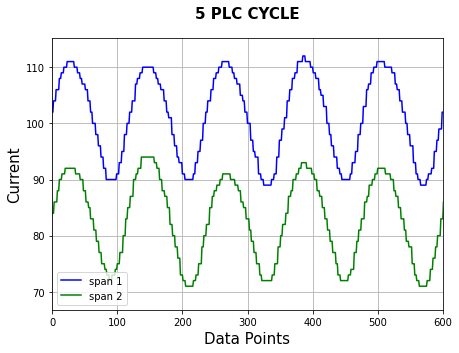

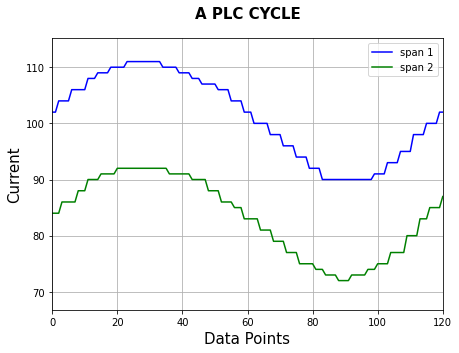

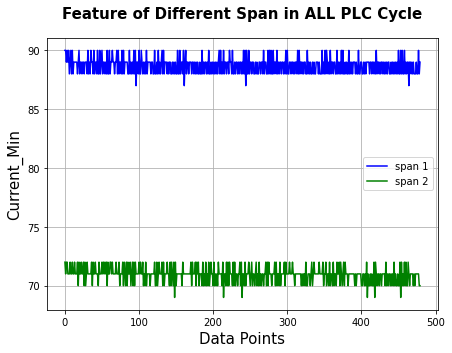

<Figure size 504x360 with 0 Axes>

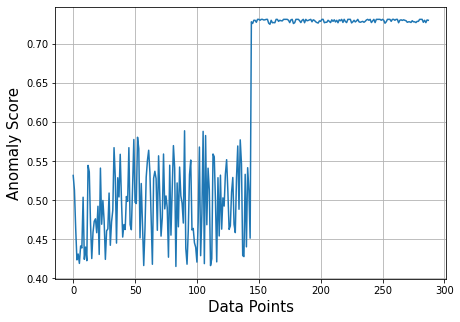

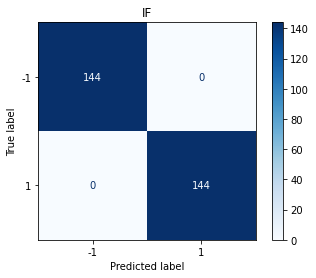

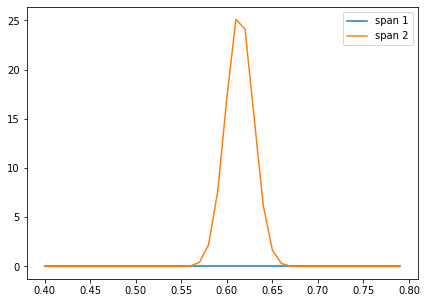

In [1]:
#%%
'''
Bayesian Optimization Isolation Forest (libaray: GPyOpt)
'''
print('Bayesian Optimization Forest...')
# BO_IF = myIsolationForest.IF(abnormal_ratio, n_estimators=50, max_samples=100, max_features=5, X_train=X_train)
BO_IF = myIsolationForest.IF(abnormal_ratio, n_estimators=200, max_samples=75, 
                             max_features=3, X_train=X_train, random_state=None)
BO_IF.Predict(X_test, y_test_bi, y_test, labels)
# BO_IF.PlotAnomalyScore('BO')

print('\t binary classification')
# label: 正常=1，異常=-1
BO_IF.ConfusionMatrixBinary([1, 2], 'BO IF')
BO_IF.ClassificationReportBinary()

BO_IF.PlotScoreHist(10, 2)


print('---End---')